In [1]:
import pandas as pd
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

from hd_var.rank_selection import rank_selection, NN_compute
from hd_var.routines.mlr.als import als_compute_closed_form
from hd_var.routines.shorr.penalization import lambda_optimal
from hd_var.routines.shorr.admm import admm_compute
from hd_var.generate import generate_A_given_rank
from hd_var.utils import normalise_y, estimate_noise_variance, differentiate, integrate_series, predict

In [2]:
Path = r"C:\Users\schoo\OneDrive\Bureau\Mines\Cours\3A\MVA\Semestre 1\Séries temporelles\Projet\project_git\data\real_data\2022-12.csv"
Path = "../report/results/realdata/2022-12.csv"
df = pd.read_csv(Path)
id_group2 = [81, 82, 83, 84, 85, 86, 87, 179, 180, 181, 227, 228, 229, 230]
df_group2 = df.iloc[:, id_group2]
df = df_group2
df_without_missing_values = df.dropna(axis=1)  # Remove columns with NA value
df_without_head = df_without_missing_values.iloc[2:]  # Remove 2 first lines of informations
df_final = df_without_head.iloc[:, 1:]  # Remove date
y = np.array(df_final).T

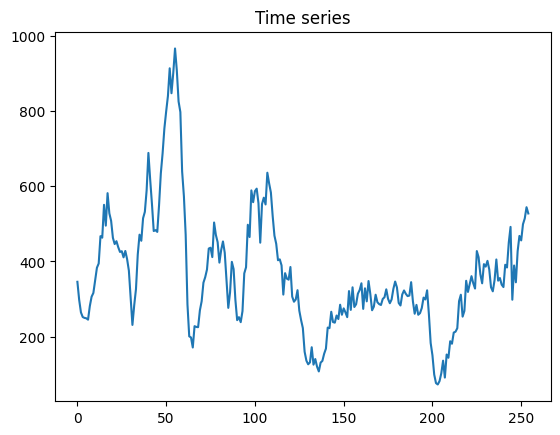

In [4]:
y_line = y[0, :]
plt.plot(y_line)
plt.title('Time series')
plt.show()

In [5]:
N = y.shape[0]
ORDER = 1
normalise = True
n_points_to_predict = 8
if normalise:
    y = normalise_y(y, -n_points_to_predict)
y_without_end = y[:, :-n_points_to_predict]
y_after_diff_without_end = y_without_end
constants = np.zeros((ORDER, N))
for ord in range(ORDER):
    constants[ord] = y_after_diff_without_end[:, 0]
    y_after_diff_without_end = differentiate(y_after_diff_without_end)

_, T = y_after_diff_without_end.shape
P = 4  # hand-chosen
lam = 1e-2 * np.log(N * N * P)  # hand-chosen

In [6]:
# Rank selection
repeat = 10
noise_var = np.zeros((N, N))
ranks_estimated = np.zeros(3)
for k in range(repeat):
    A_estimated_NN = NN_compute(y_after_diff_without_end, P, lam, A_init="random")[0]  # depends upon an initial guess.
    _ranks_estimated = rank_selection(A_estimated_NN, T)
    ranks_estimated += [int(_ranks_estimated[i]) for i in range(3)]
    noise_var += estimate_noise_variance(y_after_diff_without_end,A_estimated_NN)  # performing at the same time a noise estimation
    print(_ranks_estimated)
ranks_estimated = (ranks_estimated / repeat).astype(int)
print(ranks_estimated)
noise_var /= repeat

/home/grothendieck/high_dimensional_vector_autoregressive/venv/lib/python3.11/site-packages/jax/_src/scipy/optimize/bfgs.py:99: UserWarning: Explicitly requested dtype float64 requested in eye is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  initial_H = jnp.eye(d, dtype=x0.dtype)


[1. 1. 1.]
[1. 1. 3.]
[3. 4. 2.]
[1. 3. 2.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[2. 5. 1.]
[2. 1. 1.]
[1. 1. 1.]
[1 1 1]


In [7]:
# %% penalisation for SHORR estimate
pen_l = lambda_optimal(N, P, T, cov=noise_var)
admm = partial(admm_compute, pen_l=pen_l)

In [8]:
ranks = [1, 2, 1]  # hand-chosen
inference_routine = als_compute_closed_form  # admm 
it = 0
while True and it < 1:
    try:
        it += 1
        A_rand = generate_A_given_rank(N, P, ranks)
        _, A_est, _ = inference_routine(A_init=A_rand, ranks=ranks, y_ts=y_after_diff_without_end)
        y_after_diff_pred = predict(y_after_diff_without_end, A_est, n_points_to_predict, cov=noise_var)
        y_int_pred = y_after_diff_pred
        for ord in range(ORDER):
            y_int_pred = integrate_series(constants[ORDER - 1 - ord], y_int_pred)
        break
    except ValueError:
        pass

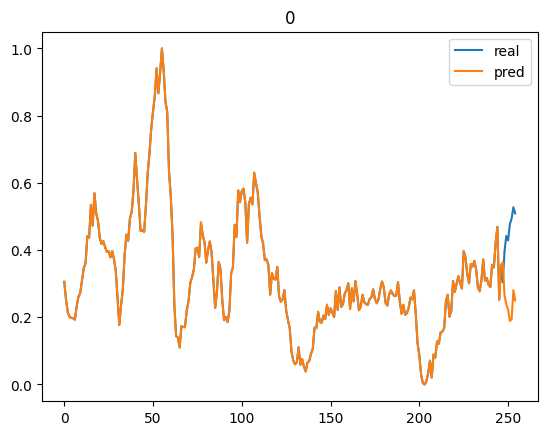

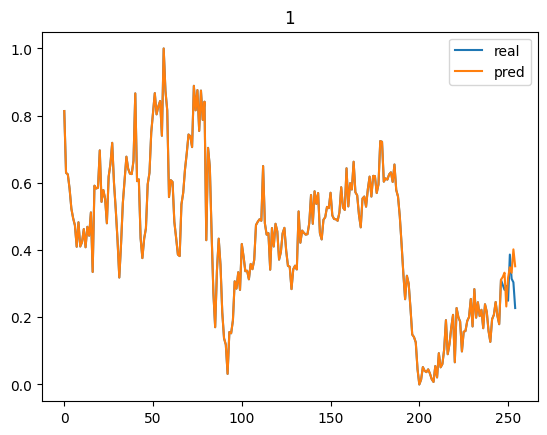

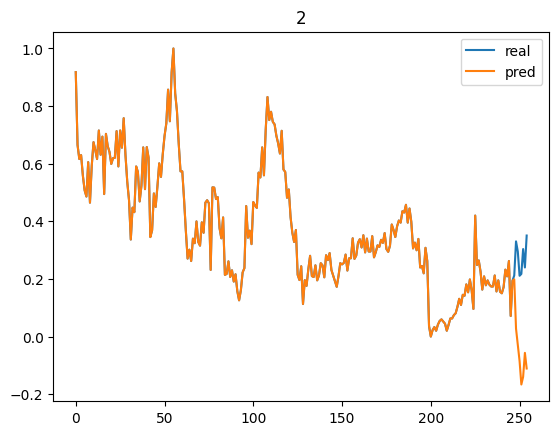

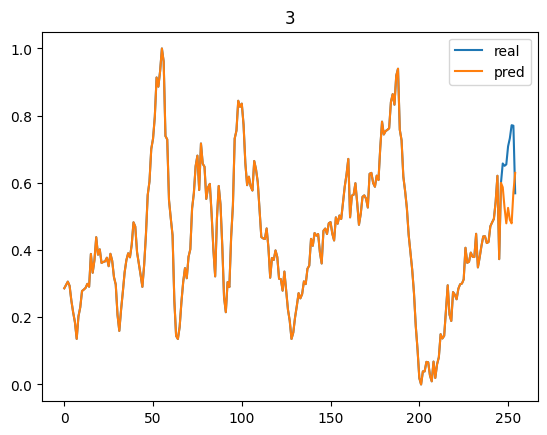

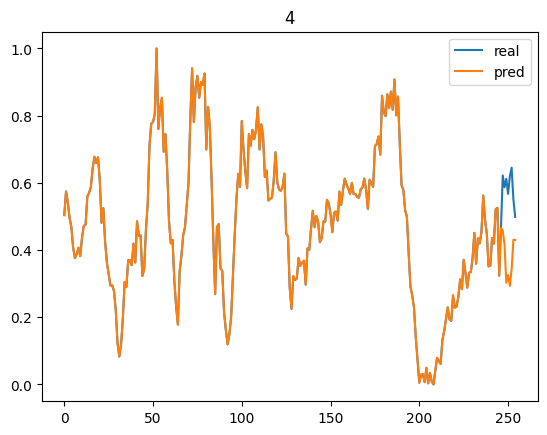

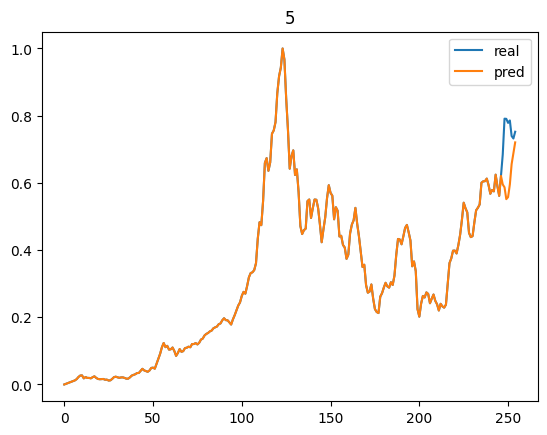

In [9]:
for j in range(N):
    y_line_pred = y_int_pred[j, :]
    y_line = y[j, :]
    plt.plot(y_line, label="real")
    plt.plot(y_line_pred, label="pred")
    plt.title(f'{j}')
    plt.legend()
    plt.show()